In [ ]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import re

init_printing()

In [5]:
""" Function of Several Variables - Функция Нескольких переменных """
class FSV(object): 
  def parse_func(self, st):
    """ 
    Возвращает строку с добавлением пропущенных знаков умножения
    """
    letters = ''
    for i in range(97, 123):
      letters += chr(i)
    digits = ''
    for i in range(48, 58):
      digits += chr(i)

    # экранируем элементарные функции
    elem_func = ['sin', 'cos', 'tan']
    for f in elem_func:
      match = re.finditer(f, st)
      for m in match:
        st = st[0:m.start()] + f'#@{m[0][0]}@{m[0][1]}@{m[0][2]}@#' + st[m.end():]
    
    i = 1
    while (i < len(st)):
      # знак умножения пропущен:
      # между переменными / перед скобкой / после скобки / перед функцией / переменная после цифры, либо цифра после переменной
      if (st[i] in letters and st[i-1] in letters) or \
      (st[i] == '(' and (st[i-1] in letters or st[i-1] in digits)) or \
        ((st[i] in letters or st[i] in digits) and st[i-1] == ')') or \
        (st[i] == '#' and (st[i-1] in digits or st[i-1] in letters)) or \
          ((st[i] in letters and st[i-1] in digits) or (st[i] in digits and st[i-1] in letters)):
        st = st[0:i] + '*' + st[i:]
        i += 1
      i += 1

    st = (st.replace('@','')).replace('#', '')
    return st


  def parse_limits(self, t): 
    """
      Возвращает полученный из переданной строки словарь, ключом которого является переменная,
      а значением кортеж вида (включительно/не включительно, значение левой границы, вкл/не вкл, знач. пр. границы)
    """
    lim = {}
    parse_x = t[0].split('<')
    parse_y = t[1].split('<') 
    def parse_part(st):
      l_s, r_s = 'ninc', 'ninc' 
      if st[1][0] == '=':
        l_s = 'inc'
        st[1] = st[1][1:]

      if st[2][0] == '=':
        r_s = 'inc'
        st[2] = st[2][1:]
      return (l_s, float(st[0]), r_s, float(st[2]))
    lim['x'] = parse_part(parse_x)
    lim['y'] = parse_part(parse_y)  
    return lim    

  def __init__(self, variables, func, lim=None, limit_func=None):
    """
       Параметры: список переменных, строковое представление функции, ограничений и ограничивающей функции
       Обрабатывает входные данные и записывает в соответствующие поля класса
    """
    # приведём кастомные значения переменных к дефолтным (x, y) как в основной ф-ции, так и в ограничивающей
    func = func.replace(str(variables[0]), 'x')
    func = func.replace(str(variables[1]), 'y')

    limit_func = limit_func.replace(str(variables[0]), 'x')
    limit_func = limit_func.replace(str(variables[1]), 'y')

    # избавимся от возможных аномалий в основной функции
    st = self.parse_func(str(func))
    # аналогично в ограничивающей, с переносом всех данных в одну часть (на случай, если было передано уравнение, а не выражение)
    st_lim = parse_expr(self.parse_func(str(limit_func.split('=')[0]))) - parse_expr(self.parse_func(str(limit_func.split('=')[1])))

    if not lim is None: # если ограничения заданы, распарсим их
      lim = self.parse_limits(lim)
    
    # записываем полученные значения в поля класса
    self.variables = variables
    self.main_f = str(st)
    self.limits = lim
    self.limit_f = str(st_lim)

  def represent(self, f_type): 
    """
      Возвращает основную / ограничивающую функцию в виде выражения SymPy,
      параметром является строка 'main' / 'limit' 
    """
    x, y = Symbol('x'), Symbol('y')
    if f_type == 'main':
      return parse_expr(self.main_f).subs([(x, self.variables[0]), (y, self.variables[1])])
    elif f_type == 'limit':
      return parse_expr(self.limit_f).subs([(x, self.variables[0]), (y, self.variables[1])])

  def solve(self):
    """
      Выполняет решение поставленной задачи
    """
    x, y, la = Symbol('x'), Symbol('y'), Symbol('la')
    f = parse_expr(self.main_f) # function
    l_f = parse_expr(self.limit_f) # limit function
    
    lambd_f = lambdify([x, y], f, 'numpy')
    langr_f = f + la*l_f

    # Производные
    dx = diff(langr_f, x)
    dy = diff(langr_f, y)

    # система уравнений
    equations = [
          Eq(dx,0),
          Eq(dy, 0),
          Eq(l_f, 0)
      ]
    
    # решением данной системой является список словарей, ключами которого являются переменные
    ans = solve(equations) 
    x_ans, y_ans, la_ans = [], [], [] # стационарные точки

    for i in ans:
      # приведем значения каждой тройки к float
      cur_x, cur_y, cur_la = float(i[x].evalf()), float(i[y].evalf()), float(i[la].evalf())
      # проверим точки на ограничения, если таковые имеются
      if not self.limits is None:
        if not (self.limits['x'][1] <=cur_x <= self.limits['x'][3]):
          continue
        if not (self.limits['y'][1] <= cur_y <= self.limits['y'][3]):
          continue
      x_ans.append(cur_x)
      y_ans.append(cur_y)
      la_ans.append(cur_la)
    
    # определитель
    dlfx = diff(l_f, x)
    dlfy = diff(l_f, y)
    ddx = diff(dx, x)
    ddy = diff(dy, y)
    ddxy = diff(dx, y)
    
    det_ans = [] # посчитанные det

    for q in range(0, len(x_ans)):
      M = np.array([[0, dlfx, dlfy],[dlfx, ddx, ddxy],[dlfy, ddxy, ddy]]) # пересчитываем матрицу
      for i in range(0, 3):
        for j in range(0,3):
          if M[i][j] != 0: # подставляем текущие значения x, y, la
            M[i][j] = M[i][j].subs(x, x_ans[q])
            M[i][j] = M[i][j].subs(y, y_ans[q])
            M[i][j] = M[i][j].subs(la, la_ans[q])
      M = Matrix(M)
      det_ans.append(M.det())
      if float(det_ans[-1].evalf()) > 0:  # Этого не достаточно: -1
        print(f"({float(x_ans[q]):.2f}, {float(y_ans[q]):.2f}) является условным максимумом")
      elif float(det_ans[-1].evalf()) < 0:  # Этого не достаточно: -1
        print(f"({float(x_ans[q]):.2f}, {float(y_ans[q]):.2f}) является условным минимумом")

    x_vec = np.arange(-5, 5, 0.05, dtype=object)
    y_vec = np.arange(-5, 5, 0.05, dtype=object)
    X, Y = np.meshgrid(x_vec, y_vec) 
    Z = lambd_f(X, Y) 

    # координаты экстремумов для нанесения 
    extr_x = np.array(x_ans, dtype=float)
    extr_y = np.array(y_ans, dtype=float)
    extr_z = lambd_f(extr_x, extr_y)
    
    fig = plt.figure(figsize=(30,10))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_wireframe(X, Y, Z, rstride=5, cstride=5) 
   
    ax.scatter3D(extr_x, extr_y, extr_z, color = "red", s=70)
    ax.set_xlabel('X Label')  
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    ax = fig.add_subplot(122)
    ax.contourf(X, Y, Z)
    ax.scatter(extr_x, extr_y, color = "red", s=70)
    
    return 'Solved successfully!'

In [9]:
task_1 = FSV(variables = ['a', 'b'], func = 'a*b', lim = ("-10<=a<=10", "-1<=b<=1"), limit_func='a**2+4*b**2-1=0')

In [10]:
task_1.represent('main')

In [11]:
task_1.represent('limit')

(-0.71, -0.35) является условным максимумом
(0.71, 0.35) является условным максимумом
(-0.71, 0.35) является условным минимумом
(0.71, -0.35) является условным минимумом


'Solved successfully!'

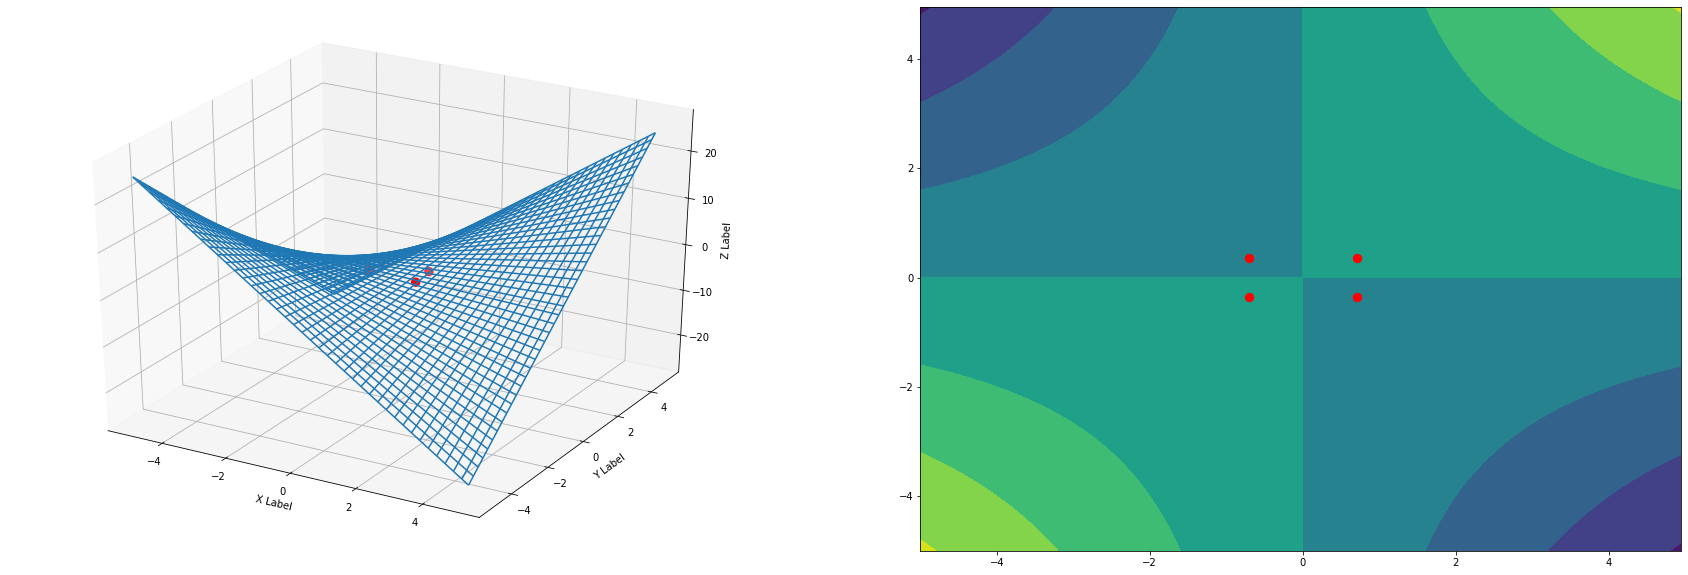

In [12]:
task_1.solve()

Введите названия переменных через пробел: a b
Введите функцию z = f(x, y): a+3b
Введите ограничивающую функцию g(x, y, z) = 0 (опционально != 0): a**2+b**2 = 10
Есть ли ограничения ? 1-да / 0-нет: 1
Введите допустимые интервалы по x: -10 10
Введите допустимые интервалы по y: -3 3
(1.00, 3.00) является условным максимумом
(-1.00, -3.00) является условным минимумом


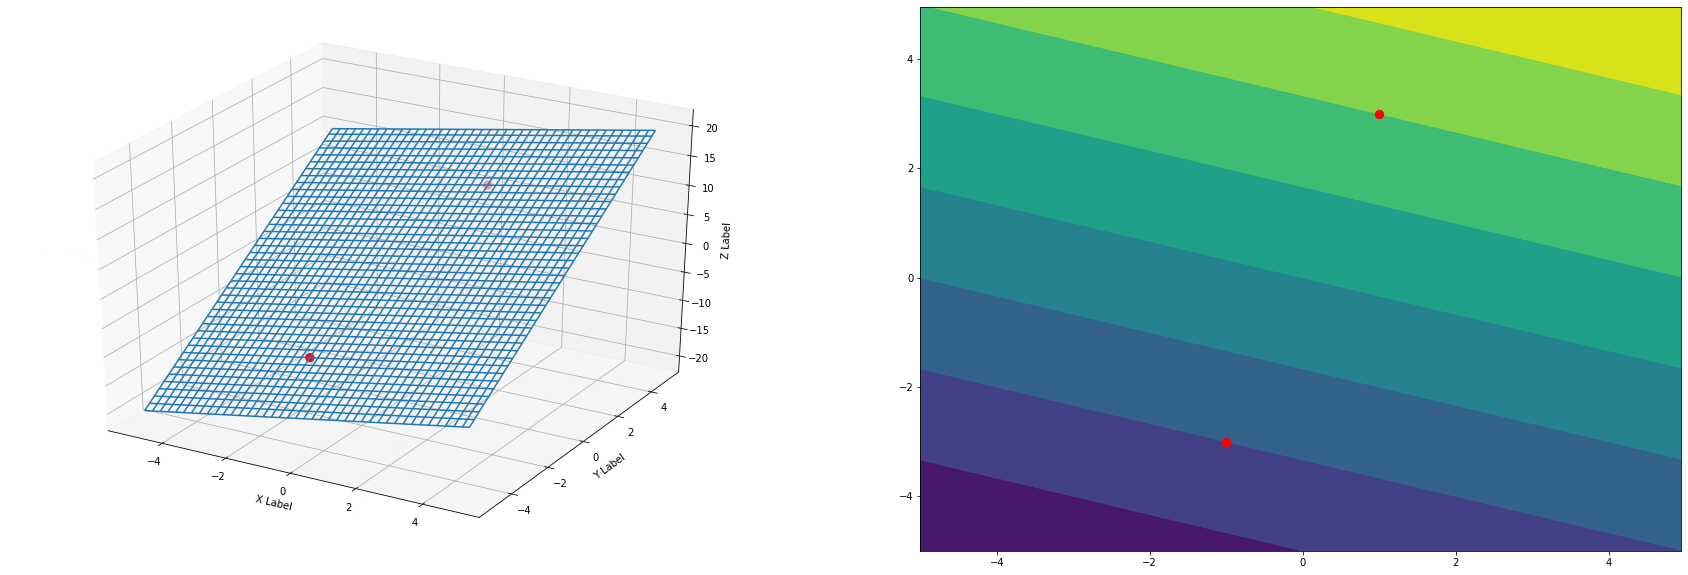

In [14]:
def wrap():
  """
    Оберточная функция для считывания данных с клавиатуры
  """
  vr = input('Введите названия переменных через пробел: ').split(' ')
  fn = input('Введите функцию z = f(x, y): ')
  lim_fn = input('Введите ограничивающую функцию g(x, y, z) = 0 (опционально != 0): ')
  if lim_fn.find('=') == -1:
    lim_fn += ' = 0'
  if_l = bool(int(input('Есть ли ограничения ? 1-да / 0-нет: ')))
  if if_l:
    l_x = input('Введите допустимые интервалы по x: ').split(' ')
    l_y = input('Введите допустимые интервалы по y: ').split(' ')
    test = FSV(variables = vr, func = fn, lim = (f"{l_x[0]}<=x<={l_x[1]}", f"{l_y[0]}<=y<={l_y[1]}"), limit_func=lim_fn)
  else:
    test = FSV(variables = vr, func = fn, limit_func=lim_fn)
  test.solve()
wrap()
# Пример входных данных:
# a b
# a+3b  
# a**2+b**2 = 10
# 1
# -10 10
# -3 3